In [1]:
from datasets import load_dataset
import os
import sys
import pandas as pd
sys.path.append("/Users/soumechenadaradjane/Documents/Frugal_challenge/")
from src.utils.eda_functions import process_text, generate_word_clouds_by_category
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("/Users/soumechenadaradjane/Documents/Frugal_challenge/outputs/train_v1.csv", sep=";")

In [3]:
train

quote  \
0     There is clear, compelling evidence that many ...   
1     For most of the Holocene (last 10k years), sea...   
2     China, which hosts U.N. climate talks next wee...   
3     And the fabricated documents (which Dr. Mann a...   
4     It's going to be 42 here today and the hottest...   
...                                                 ...   
6086  There is that sense of the Senate that climate...   
6087  This is the biggest scientific hoax being perp...   
6088  A world with no tobacco might sound appealing ...   
6089  The relationship between CO2 and temperature i...   
6090  Whatever is happening to the weather at the mo...   

                                label  source  \
0                5_science_unreliable   FLICC   
1                     1_not_happening   FLICC   
2     4_solutions_harmful_unnecessary   FLICC   
3                      0_not_relevant   FLICC   
4                     1_not_happening   FLICC   
...                               ...     ...   
6086              6_proponents_biased  Desmog   
6087                      2_not_human  Desmog   
6088                   0_not_relevant  Desmog   
6089             5_science_unreliable  Desmog   
6090                  1_not_happening  Desmog   

                                                    url language  \
0     https://huggingface.co/datasets/fzanartu/FLICC...       en   
1     https://huggingface.co/datasets/fzanartu/FLICC...       en   
2     https://huggingface.co/datasets/fzanartu/FLICC...       en   
3     https://huggingface.co/datasets/fzanartu/FLICC...       en   
4     https://huggingface.co/datasets/fzanartu/FLICC...       en   
...                                                 ...      ...   
6086               https://www.desmog.com/kevin-cramer/       en   
6087                  https://www.desmog.com/tad-murty/       en   
6088               https://www.desmog.com/drew-johnson/       en   
6089            https://www.desmog.com/junkscience-com/       en   
6090              https://www.desmog.com/boris-johnson/       en   

          subsource  id  __index_level_0__  \
0             CARDS NaN                  0   
1     hamburg_test1 NaN                  1   
2             CARDS NaN                  2   
3             CARDS NaN                  3   
4     hamburg_test3 NaN                  4   
...             ...  ..                ...   
6086            NaN NaN               6431   
6087            NaN NaN               6432   
6088            NaN NaN               6433   
6089            NaN NaN               6435   
6090            NaN NaN               6436   

                                        processed_quote  
0     ['clear', 'compelling', 'evidence', 'many', 'm...  
1     ['holocene', 'last', '10k', 'year', 'sea', 'le...  
2     ['china', 'host', 'un', 'climate', 'talk', 'ne...  
3     ['fabricate', 'document', 'dr', 'mann', 'appar...  
4     ['be', 'go', '42', 'today', 'hot', 'summer', '...  
...                                                 ...  
6086  ['sense', 'senate', 'climate', 'change', 'real...  
6087  ['big', 'scientific', 'hoax', 'perpetrate', 'h...  
6088  ['world', 'tobacco', 'might', 'sound', 'appeal...  
6089  ['relationship', 'co2', 'temperature', 'logari...  
6090  ['whatever', 'happen', 'weather', 'moment', 's...  

[6091 rows x 9 columns]

In [4]:
train["label"].value_counts()

label
0_not_relevant                     1618
5_science_unreliable                801
6_proponents_biased                 782
4_solutions_harmful_unnecessary     774
1_not_happening                     741
2_not_human                         702
3_not_bad                           386
7_fossil_fuels_needed               287
Name: count, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3))  # Remove common English stop words
X = vectorizer.fit_transform(train['quote'])  # X contains the TF-IDF representation of the text

# Step 2: Prepare the target variable (label)
y = train['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 4: Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", max_depth = 60)   # You can tweak the parameters as needed
model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                                 precision    recall  f1-score   support

                 0_not_relevant       0.60      0.66      0.63       486
                1_not_happening       0.52      0.72      0.61       222
                    2_not_human       0.57      0.67      0.61       211
                      3_not_bad       0.77      0.34      0.48       116
4_solutions_harmful_unnecessary       0.51      0.53      0.52       232
           5_science_unreliable       0.55      0.52      0.53       240
            6_proponents_biased       0.47      0.31      0.38       235
          7_fossil_fuels_needed       0.54      0.42      0.47        86

                       accuracy                           0.56      1828
                      macro avg       0.57      0.52      0.53      1828
                   weighted avg       0.56      0.56      0.55      1828



In [6]:
# Optionally, to check feature importance (which features contribute to the predictions)
importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
feature_importance_dict = {feature_names[i]: importances[i] for i in range(len(importances))}
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 Important Features:")
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance:.4f}")


Top 10 Important Features:
natural gas: 0.0134
science: 0.0133
fossil fuels: 0.0132
co2: 0.0117
change: 0.0115
fossil fuel: 0.0098
atmospheric: 0.0092
sun: 0.0092
plant growth: 0.0089
settled: 0.0084


In [7]:
# Step 1: Use Sentence-BERT to convert text to embeddings
model = SentenceTransformer('all-MPNet-base-v2')  # You can use other pretrained models as well

# Convert each sentence into a vector representation (embedding)
embeddings = model.encode(train['quote'].tolist())

# Step 2: Prepare the target variable (label)
y = train['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.3, random_state=42, stratify=y)

# Step 4: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")  # You can tweak the parameters as needed
rf_model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = rf_model.predict(X_test)

# Step 6: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                                 precision    recall  f1-score   support

                 0_not_relevant       0.59      0.78      0.67       486
                1_not_happening       0.69      0.75      0.72       222
                    2_not_human       0.64      0.64      0.64       211
                      3_not_bad       0.86      0.43      0.57       116
4_solutions_harmful_unnecessary       0.56      0.62      0.59       232
           5_science_unreliable       0.59      0.49      0.53       240
            6_proponents_biased       0.58      0.43      0.50       235
          7_fossil_fuels_needed       0.66      0.36      0.47        86

                       accuracy                           0.61      1828
                      macro avg       0.65      0.56      0.59      1828
                   weighted avg       0.62      0.61      0.61      1828



In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def plot_embeddings_2d_with_text_labels(df, embedding_column, label_column, method='PCA', random_state=42):
    """
    This function reduces high-dimensional embeddings into 2D and visualizes them with textual labels.

    Args:
        df (pd.DataFrame): DataFrame containing the text data and labels.
        embedding_column (str): The column containing the embeddings.
        label_column (str): The column containing the textual labels.
        method (str): The dimensionality reduction method ('PCA' or 'tSNE').
        random_state (int): Random state for reproducibility.
    """
    # Step 1: Use dimensionality reduction (PCA or t-SNE)
    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=random_state)
    elif method == 'tSNE':
        reducer = TSNE(n_components=2, random_state=random_state)
    else:
        raise ValueError("Invalid method. Use 'PCA' or 'tSNE'.")
    
    # Reduce the embeddings to 2D
    embeddings_2d = reducer.fit_transform(df[embedding_column].tolist())
    
    # Step 2: Map textual labels to numeric values (for coloring purposes)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(df[label_column])
    
    # Step 3: Plot the 2D embeddings
    plt.figure(figsize=(10, 8))
    
    # Scatter plot, coloring points by their label
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=numeric_labels, cmap='viridis')
    
    # Create a legend for the textual labels (mapped to numeric values)
    plt.legend(*scatter.legend_elements(), title="Classes")
    
    # Adding labels and title
    plt.title("2D Visualization of Embeddings with Text Labels")
    plt.xlabel("Principal Component 1" if method == 'PCA' else "t-SNE Dimension 1")
    plt.ylabel("Principal Component 2" if method == 'PCA' else "t-SNE Dimension 2")
    
    plt.colorbar(scatter)
    
    plt.show()

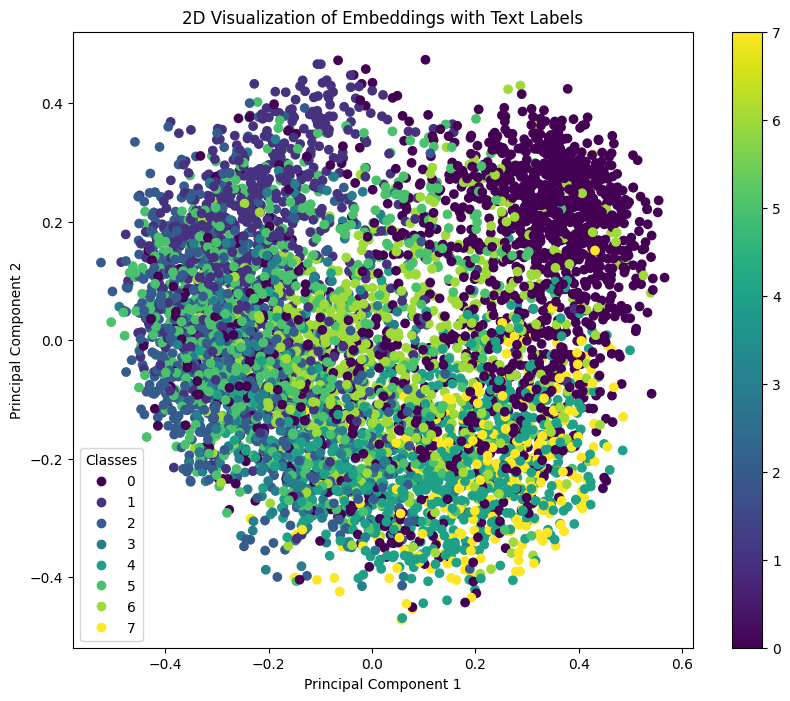

In [9]:
# Add embeddings to DataFrame
train['embeddings'] = list(embeddings)

# Step 2: Plot the embeddings in 2D
plot_embeddings_2d_with_text_labels(train, embedding_column='embeddings', label_column='label', method='PCA')  # or 'tSNE

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot_embeddings_3d_with_text_labels(df, embedding_column, label_column, method='PCA', random_state=42):
    """
    This function reduces high-dimensional embeddings into 3D and visualizes them with textual labels.

    Args:
        df (pd.DataFrame): DataFrame containing the text data and labels.
        embedding_column (str): The column containing the embeddings.
        label_column (str): The column containing the textual labels.
        method (str): The dimensionality reduction method ('PCA' or 'tSNE').
        random_state (int): Random state for reproducibility.
    """
    # Step 1: Use dimensionality reduction (PCA or t-SNE)
    if method == 'PCA':
        reducer = PCA(n_components=3, random_state=random_state)
    elif method == 'tSNE':
        reducer = TSNE(n_components=3, random_state=random_state)
    else:
        raise ValueError("Invalid method. Use 'PCA' or 'tSNE'.")
    
    # Reduce the embeddings to 3D
    embeddings_3d = reducer.fit_transform(df[embedding_column].tolist())
    
    # Step 2: Map textual labels to numeric values (for coloring purposes)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(df[label_column])
    
    # Step 3: Plot the 3D embeddings
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot, coloring points by their label
    scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=numeric_labels, cmap='viridis')
    
    # Create a legend for the textual labels (mapped to numeric values)
    ax.legend(*scatter.legend_elements(), title="Classes")
    
    # Adding labels and title
    ax.set_title("3D Visualization of Embeddings with Text Labels")
    ax.set_xlabel("Principal Component 1" if method == 'PCA' else "t-SNE Dimension 1")
    ax.set_ylabel("Principal Component 2" if method == 'PCA' else "t-SNE Dimension 2")
    ax.set_zlabel("Principal Component 3" if method == 'PCA' else "t-SNE Dimension 3")
    
    # Show the plot
    plt.show()

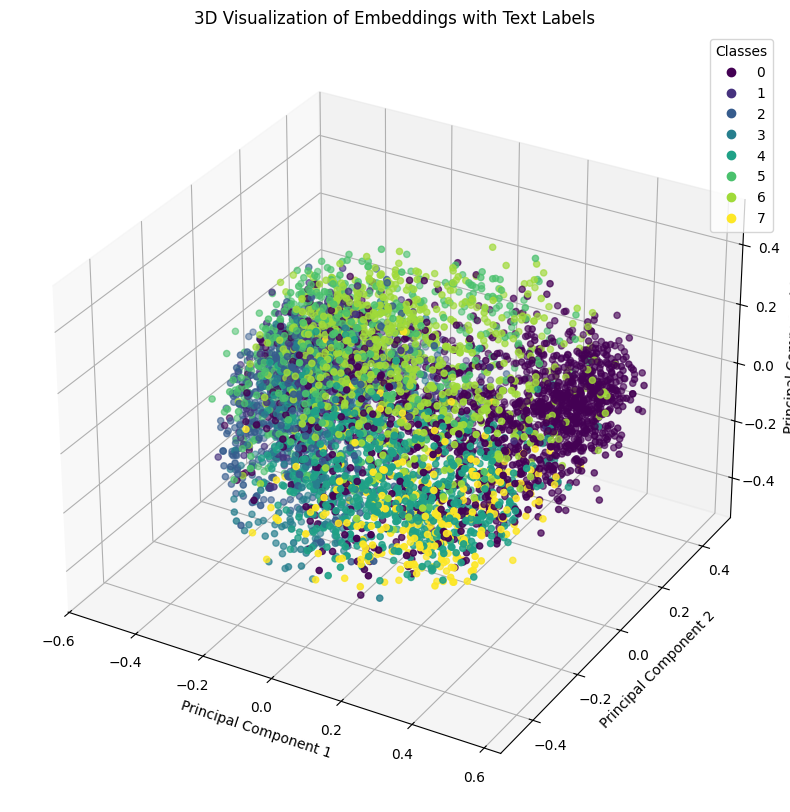

In [11]:
# Add embeddings to DataFrame
train['embeddings'] = list(embeddings)

# Step 2: Plot the embeddings in 2D
plot_embeddings_3d_with_text_labels(train, embedding_column='embeddings', label_column='label', method='PCA')  # or 'tSNE